In [33]:
from typing import Any, Callable, Literal, Union

import pandas as pd
import torch
import torchvision.transforms as transforms
import wandb
from tqdm import tqdm

from gorillatracker.datasets.cxl import CXLDataset
from gorillatracker.model import BaseModule


def load_model_from_wandb(
    wandb_fullname: str, model_cls: BaseModule = BaseModule(), embedding_size: int = 128, device: str = "cpu"
) -> BaseModule:
    wandb.login()
    wandb.init(mode="disabled")
    api = wandb.Api()

    artifact = api.artifact(  # type: ignore
        wandb_fullname,
        type="model",
    )
    artifact_dir = artifact.download()
    model = artifact_dir + "/model.ckpt"  # all of our models are saved as model.ckpt
    checkpoint = torch.load(model, map_location=torch.device("cpu"))
    model_state_dict = checkpoint["state_dict"]

    model = model_cls(
        embedding_size=embedding_size,
    )

    if not hasattr(model_state_dict, "loss_module_train.prototypes") or not hasattr(
        model_state_dict, "loss_module_val.prototypes"
    ):  # necessary because arcface loss also saves prototypes
        model.loss_module_train.prototypes = torch.nn.Parameter(model_state_dict["loss_module_train.prototypes"])
        model.loss_module_val.prototypes = torch.nn.Parameter(model_state_dict["loss_module_val.prototypes"])

    model.load_state_dict(model_state_dict)
    model.to(device)
    model.eval()
    return model


def generate_embeddings(model: BaseModule, dataset: Any, device: str = "cpu") -> pd.DataFrame:
    embeddings = []
    df = pd.DataFrame(columns=["embedding", "label", "input", "label_string"])
    with torch.no_grad():
        print("Generating embeddings...")
        for imgs, labels in tqdm(dataset):
            if isinstance(imgs, torch.Tensor):  # if single image is passe wrap it in list
                imgs = [imgs]
                labels = [labels]
            batch_inputs = torch.stack(imgs)
            if batch_inputs.shape[0] != 1:
                batch_inputs = batch_inputs.unsqueeze(1)
            batch_inputs = batch_inputs.to(device)
            embeddings = model(batch_inputs)

            for i in range(len(imgs)):
                input_img = transforms.ToPILImage()(batch_inputs[i].cpu())
                df = pd.concat(
                    [
                        df,
                        pd.DataFrame(
                            {
                                "embedding": [embeddings[i]],
                                "label": [labels[i]],
                                "input": [input_img],
                                "label_string": [dataset.mapping[labels[i]]] if dataset.mapping else None,
                            }
                        ),
                    ]
                )
    df.reset_index(drop=False, inplace=True)
    return df


def get_dataset(
    partition: Literal["train", "val", "test"] = "val",
    data_dir: str = "/workspaces/gorillatracker/data/splits/ground_truth-cxl-face_images-openset-reid-val-0-test-0-mintraincount-3-seed-42-train-50-val-25-test-25",
    transform: Union[Callable[..., Any], None] = None,
    model: BaseModule = BaseModule(),
) -> CXLDataset:
    if transform is None:
        transform = transforms.Compose(
            [
                CXLDataset.get_transforms(),
                model.get_tensor_transforms(),
            ]
        )

    return CXLDataset(
        data_dir=data_dir,
        partition=partition,
        transform=transform,
    )

## Code used for loading in another notebook

In [35]:
from gorillatracker.model import EfficientNetV2Wrapper

model = load_model_from_wandb("gorillas/Embedding-ALL-SPAC-Open/model-3ag1c2vf:v1", EfficientNetV2Wrapper, 128, "cpu")
dataset = get_dataset(model=EfficientNetV2Wrapper)
df = generate_embeddings(model, dataset, "cpu")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Downloading large artifact model-3ag1c2vf:v1, 1346.85MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.9


Generating embeddings...


100%|██████████| 126/126 [00:21<00:00,  5.98it/s]


In [36]:
print(df.head())

   index                                          embedding label  \
0      0  [tensor(-0.8330), tensor(0.8129), tensor(-0.61...     2   
1      0  [tensor(-0.7051), tensor(0.0975), tensor(0.475...    15   
2      0  [tensor(-0.0965), tensor(0.5661), tensor(0.574...     9   
3      0  [tensor(-0.7616), tensor(0.5925), tensor(-0.65...    26   
4      0  [tensor(-1.2074), tensor(1.5008), tensor(-0.36...    21   

                                               input label_string  
0  <PIL.Image.Image image mode=RGB size=224x224 a...         HU40  
1  <PIL.Image.Image image mode=RGB size=224x224 a...         TU03  
2  <PIL.Image.Image image mode=RGB size=224x224 a...         PL00  
3  <PIL.Image.Image image mode=RGB size=224x224 a...         YE40  
4  <PIL.Image.Image image mode=RGB size=224x224 a...         US01  


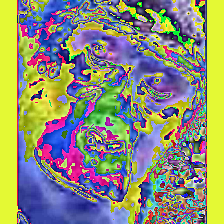

In [37]:
# show sample image
sample_img = df["input"][0]
sample_img.show()

In [ ]:
"""wandb.login()
wandb.init(mode="disabled")
api = wandb.Api()

artifact = api.artifact(
    "gorillas/Embedding-ALL-SPAC-Open/model-3ag1c2vf:v1",  # your artifact name
    type="model",
)
artifact_dir = artifact.download()
model = artifact_dir + "/model.ckpt"

# load model
checkpoint = torch.load(model, map_location=torch.device("cpu"))

model = EfficientNetV2Wrapper(  # switch this with the model you want to use
    model_name_or_path="EfficientNetV2_Large",
    from_scratch=False,
    loss_mode="softmax/arcface",
    weight_decay=0.001,
    lr_schedule="cosine",
    warmup_mode="cosine",
    warmup_epochs=10,
    max_epochs=100,
    initial_lr=0.01,
    start_lr=0.01,
    end_lr=0.0001,
    beta1=0.9,
    beta2=0.999,
    embedding_size=128,
)
# the following lines are necessary to load a model that was trained with arcface (the prototypes are saved in the state dict)
model.loss_module_train.prototypes = torch.nn.Parameter(checkpoint["state_dict"]["loss_module_train.prototypes"])
model.loss_module_val.prototypes = torch.nn.Parameter(checkpoint["state_dict"]["loss_module_val.prototypes"])

model.load_state_dict(checkpoint["state_dict"])
model.eval()

# generate table that contains labels and images and embeddings
df = pd.DataFrame(columns=["label", "image", "embedding"])
dataset = CXLDataset(
    data_dir="/workspaces/gorillatracker/data/splits/ground_truth-cxl-face_images-openset-reid-val-0-test-0-mintraincount-3-seed-42-train-50-val-25-test-25",
    partition="val",
    transform=transforms.Compose(  # use the transforms that were used for the model (except of course data augmentations)
        [
            SquarePad(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ]
    ),
)

for i in range(len(dataset)):
    image_tensor, label = dataset[i]
    label_string = dataset.mapping[label]
    image = transforms.ToPILImage()(image_tensor)
    image_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.228, 0.224, 0.225])(
        image_tensor
    )  # if your model was trained with normalization, you need to normalize the images here as well
    embedding = model(image_tensor.unsqueeze(0))
    df = pd.concat(
        [
            df,
            pd.DataFrame(
                {
                    "label_string": [label_string],
                    "label": [label],
                    "image": [image],
                    "embedding": [embedding[0].detach().numpy()],
                }
            ),
        ]
    )

    if i % 10 == 0:
        print(f"\rprocessed {i} images")
df = df.reset_index(drop=False)"""